# Отборочное задание №1 на стажировку в команду Core ML VK: 
Реализуйте максимально эффективным образом алгоритм иерархической кластеризации с алгоритмом объединения single-link clustering для точек, расположенных на прямой. Опишите алгоритм, а также найдите пример, когда подобный алгоритм показывает «плохие» результаты. ([ссылка на заявку](https://vk.com/jobs?w=job117))

## Решает задачу:
Лисоветин Никита Валерьевич ([github](https://github.com/turing228), [vk](https://vk.com/nikitalisovetin))

# Решение за O(n^2): библиотечное
"Считерим" и используем библиотечный метод ([scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)) для точек в сколь угодно мерном пространстве. Нам гарантируют время работы O(n^2), где n - количество точек.

Эта асимптотика легко достигается и без библиотек ([single-link clustering](https://nlp.stanford.edu/IR-book/completelink.html))

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = [[i] for i in [6, 7, 1, 3, 2, 15, 20]]

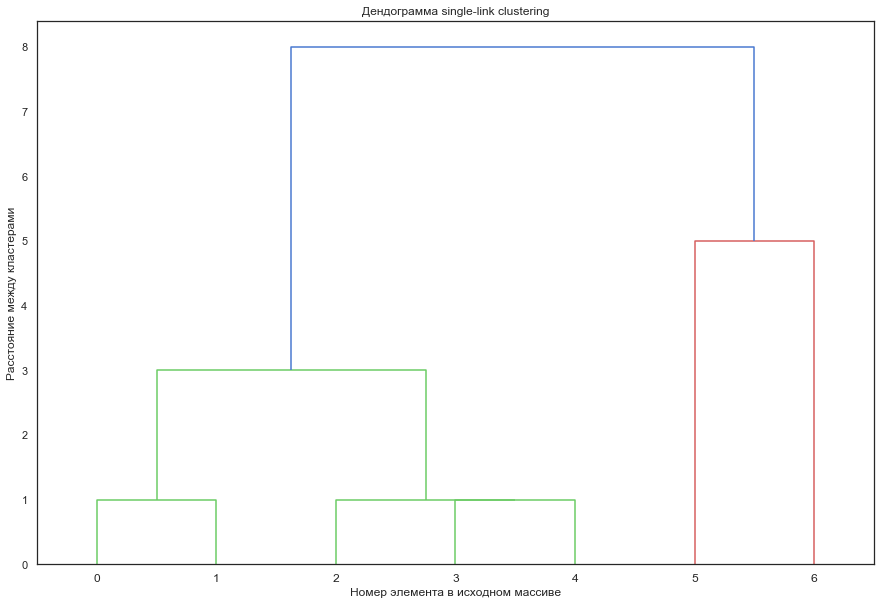

In [4]:
Z = linkage(X, 'single')
fig = plt.figure(figsize=(15, 10))
plt.title('Дендограмма single-link clustering')
plt.xlabel('Номер элемента в исходном массиве')
plt.ylabel('Расстояние между кластерами')
dn = dendrogram(Z)
plt.show()

# Как интерпретировать дендограмму?
Номера снизу - номера элементов в массиве X

## Как выглядит массив Z?

[[номер первого элемента, номер второго элемента (если >=n, то номер строчки Z + n-1), расстояние на котором объединили, сколько точек], ...]

In [5]:
Z

array([[ 0.,  1.,  1.,  2.],
       [ 3.,  4.,  1.,  2.],
       [ 2.,  8.,  1.,  3.],
       [ 7.,  9.,  3.,  5.],
       [ 5.,  6.,  5.,  2.],
       [10., 11.,  8.,  7.]])

# Решение за O(nlog(n)): собственное

Воспользуемся тем, что точки на прямой, а не в пространстве - у нас существуют явный порядок на множестве. Это дает возможность быстро находить минимальное расстояние между кластерами (теперь это одно из O(n) расстояний между соседними кластерами, а не одно из O(n^2) между какими-то двумя)

Кластеры будем хранить как DSU (систему непересекающихся множеств)

## Алгоритм:

1. Инициализируем DSU
2. Сортируем точки за O(nlog(n)) и сохраняем в sortedArray, запоминая исходные номера точек
3. Сохраняем расстояния между соседними точками в отсортированный по расстояниям neighborsDistMap за O(nlogn)
4. Делаем n-1 merge:
    1. Берем очередной минимальный отрезок между соседними вершинками из neighborsDistMap
    2. Если вершинки из одного кластера, переходим к 1. Иначе объединяем кластеры в DSU в вершину с новым номером

## Асимптотика:

Первые 3 шага, как видно, выполняются за O(nlog(n))

Шаг 4.A. всего выполним не более n-1 раз, так как |neighborsDistMap| = n-1

В шаге 4.B. объединение кластеров в моем решении с эвристиками объединения по рангу и сжатия пути происходит за O(alpha(n)) в среднем, где alpha() - обратная функция Аккермана, растущая очень медленно (<=4 для n <= 10^600) ([DSU объединение эвристик](http://www.e-maxx-ru.1gb.ru/algo/dsu#7))

**Итоговая асимптотика:** O(nlog(n))

## Можно ли быстрее?

Нет.

При построении дендограммы мы, объединяя два кластера, можем за O(1) узнать порядок кластеров на прямой. Давайте узнавать, это не изменит асимптотику. 

Любые две точки изначально в разных кластерах, а в конце - в одном, поэтому был первый момент, когда мы объединили их в один кластер. В этот момент мы узнаем какая левее какой.

Так как точки были любыми, то мы узнали порядок любых точек на прямой. Но любой алгоритм, упорядочивающий n чисел (означающих точки на прямой) сравнениями, в худшем случае выполняет хотя бы Ω(nlog(n) сравнений! ([теорема о нижней оценке для сортировки сравнениями](https://neerc.ifmo.ru/wiki/index.php?title=Теорема_о_нижней_оценке_для_сортировки_сравнениями)).

Поэтому алгоритм, решающий данную задачу, не может работать быстрее, чем за O(nlog(n))

In [6]:
import numpy as np

class DSU:
    def __init__(self, n):
        self.n = n
        self.N = n
        self.parent = np.array([i for i in range(2*n)])
        self.rank = np.zeros(2*n)
        self.volume = np.concatenate([np.ones(n), np.zeros(n)])

    def findSet(self, v):
        v = int(v)
        if (v == self.parent[v]):
            return v
        self.parent[v] = self.findSet(self.parent[v])
        return self.parent[v]

    def unionSets(self, a, b):
        a = self.findSet(a)
        b = self.findSet(b)
        if (a != b):
            if (self.rank[a] < self.rank[b]):
                a, b = b, a
            self.volume[self.N] = self.volume[self.parent[a]] + self.volume[self.parent[b]]
            self.parent[b] = self.N
            self.parent[a] = self.N
            self.N += 1
            if (self.rank[a] == self.rank[b]):
                self.rank[a] += 1
            return (self.volume[self.N - 1])

In [22]:
class SingleLink:    
    def __init__(self, array, maxNumClusters = 1):
        self.n = len(array)
        
        if (maxNumClusters > self.n):
            maxNumClusters = self.n
            print('Указано слишком большое число кластеров. Число кластеров понижено до n')
        self.maxNumClusters = maxNumClusters
        
        def getSorted():
            preSortedArray = []
            for i in enumerate(array):
                preSortedArray.append(i)
            def takeSecond(element):
                return element[1]
            return np.array(sorted(preSortedArray,key=takeSecond))
        
        self.sortedArray = getSorted()
        
        
        def getNeighborsDistMap():
            neighborsDistMap = []
            for i in range(self.n - 1):
                x = self.sortedArray[i]
                y = self.sortedArray[i + 1]
                neighborsDistMap.append((y[1] - x[1], [x[0], y[0]]))

            return sorted(neighborsDistMap)
        
        self.neighborsDistMap = getNeighborsDistMap()
        
        self.lastDistance = 0
        self.prevDistance = 0
        self.numClusters = self.n
        
        def link():
            dsu = DSU(self.n)
            Z = []
            self.numClusters = self.n
            for trio in self.neighborsDistMap:
                d = trio[0]
                x = dsu.findSet(trio[1][0])
                y = dsu.findSet(trio[1][1])
                z = dsu.unionSets(x, y)
                if (x != y):
                    if (self.numClusters >= self.maxNumClusters):
                        self.prevDistance = self.lastDistance
                        self.lastDistance = d
                        self.numClusters -= 1
                    
                    Z.append([x, y, d, z])
                    
            if (self.maxNumClusters != 1):
                self.numClusters += 1            
            return np.array(Z)
        
        self.Z = link()
        
    def draw(self):
        fig = plt.figure(figsize=(15, 10))
        plt.title(f'Дендограмма single-link clustering. Число кластеров {self.numClusters}')
        plt.xlabel('Номер элемента в исходном массиве')
        plt.ylabel('Расстояние между кластерами')
        
        if (self.maxNumClusters != 1):
            plt.axhline((self.lastDistance + self.prevDistance) / 2)
            
        dn = dendrogram(self.Z)
        plt.show()

In [23]:
slink = SingleLink([6, 7, 1, 3, 2, 15, 20], 3)

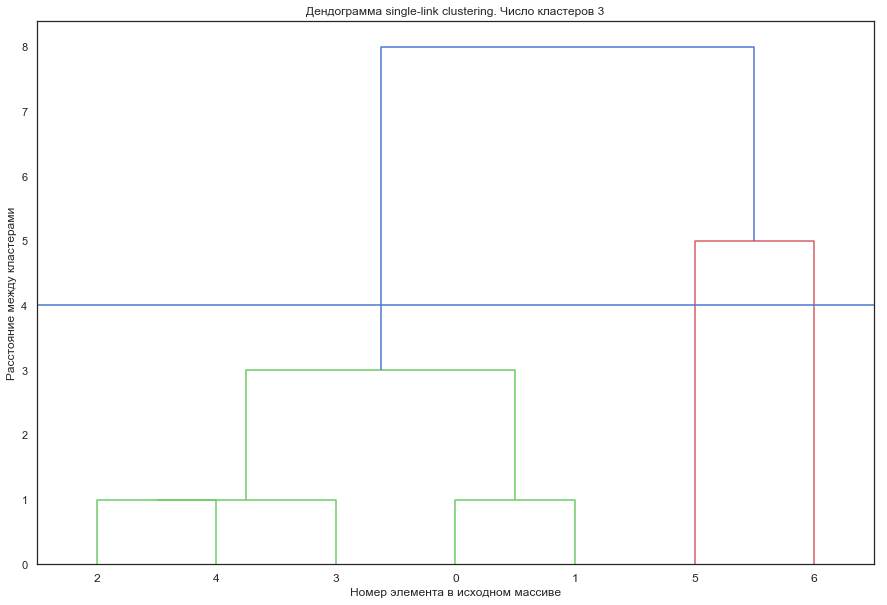

In [24]:
slink.draw()

# Проверка времени работы
Покажем, что асимптотика времени выполнения O(nlogn), а не O(n^2)

In [8]:
import time

ax = []
ay = []
x = 0
for i in range(20):
    x += 10000
    start = time.time()
    slink = SingleLink(np.random.rand(x))
    end = time.time()
    ax.append(x)
    ay.append(end - start)
    print(x, end - start)

10000 0.12314391136169434
20000 0.2734806537628174
30000 0.3675649166107178
40000 0.6083571910858154
50000 0.815222978591919
60000 0.8617048263549805
70000 1.0495412349700928
80000 1.3160943984985352
90000 1.6853818893432617
100000 1.5691249370574951
110000 1.7007050514221191
120000 1.6252367496490479
130000 2.154059886932373
140000 2.6862878799438477
150000 2.954718828201294
160000 2.5013208389282227
170000 3.108888864517212
180000 3.4546878337860107
190000 3.910606861114502
200000 3.4975321292877197


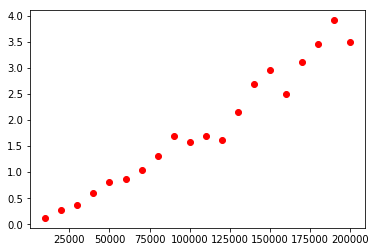

In [9]:
import matplotlib.pyplot as plt

plt.plot(ax, ay, 'ro')
#plt.axis([0, 6, 0, 20])
plt.show()

## Вывод:

Это явно не O(n^2) и очень похоже на O(n), что недалеко от O(nlogn)

# Когда такой алгоритм показывает "плохие" результаты?

"Плохие" в смысле времени работы:
1. Когда наш массив worst case для нашего алгоритма сортировки и мы могли бы сразу выдать single-link clustering. Стоит заметить, что в Python sort алгоритм - Timsort ([python sort time complexity](https://stackoverflow.com/questions/14434490/what-is-the-complexity-of-this-python-sort-method)), который adaptive sorting algoritm, то есть, например, работающий за линию в случае получения упорядоченного массива

"Плохие" в смысле качества кластеризации:
1. Single link clustering сравнивает расстояния между кластерами, забывая про размер и "длину" кластеров (то есть крайние точки кластера могут уже быть сильно дальше друг от друга, чем расстояния между кластерами, но кластер продолжит расширяться). Это, безусловно, противоречит с идеей кластеризации - поиска точек сгущений (областей с глобально высокой плотностью точек). И приводит к проблемам, когда результат непонятно как интерпретировать

## Рассмотрим несколько примеров

## Пример №1. Хороший

In [26]:
d = np.random.RandomState(312302).normal(size=150)/3

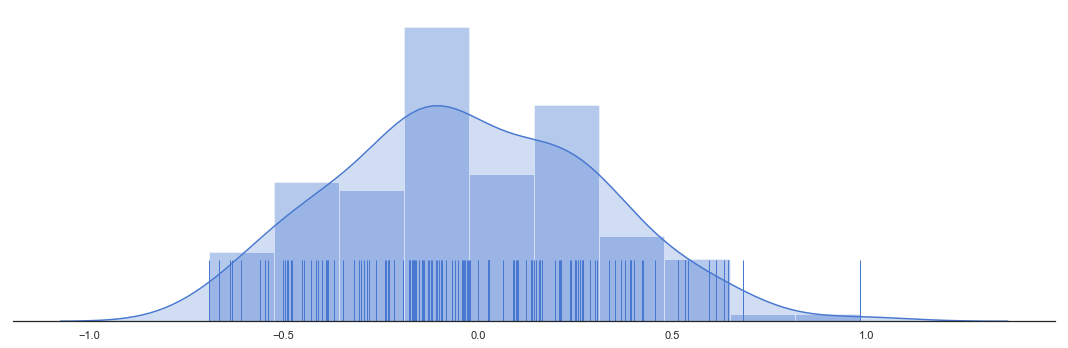

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:

Это нормальное распределение от -1 до +1. В 0 точек больше всего, к краям - меньше. Ожидаемый кластер в 0. Если присмотреться (на столбцы частотности), то есть еще кластеры с центрами в -0.5 и в 0.3

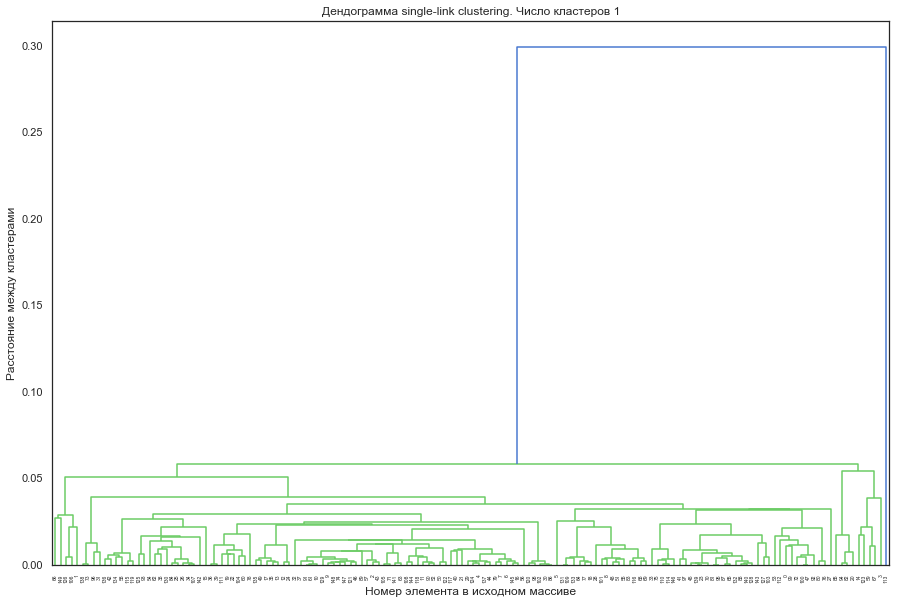

In [28]:
SingleLink(d).draw()

## Вывод:
И как выбрать число кластеров? Поможет ли нам такая кластеризация? Возможно, более жесткие критерии дали бы лучшие результаты (близость точек), но в single-link clustering их нет. Мы не видим никакой разницы между скоплениями точек.

Если мы видим график сверху, то, естественно, следует пытаться кластеризовать четче (правда, иногда это невозможно). Поэтому проверку программа можно считать, что прошла.

## Пример №2
Теперь объединим несколько нормальных распределений

In [29]:
d = np.concatenate((np.random.RandomState(10).normal(size=500)/3, np.random.RandomState(10).normal(size=500)/3+1.4))

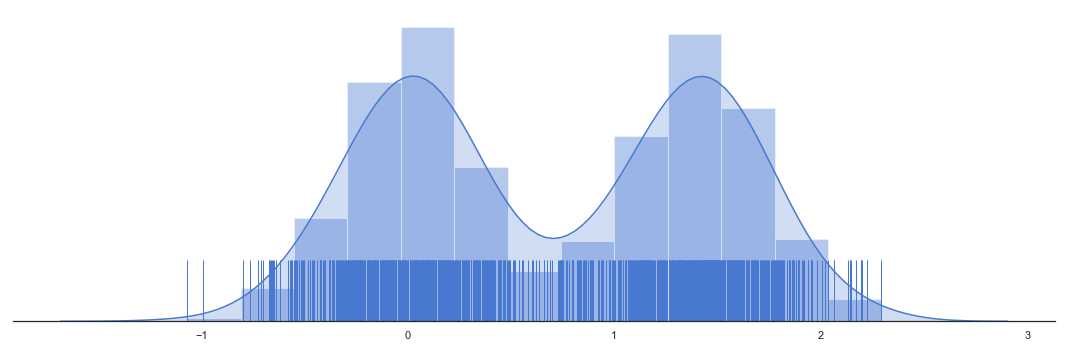

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:
Два больших кластера с центрами в 0 и 1.5 и, возможно, несколько маленьких (они видны в середине и по краям)

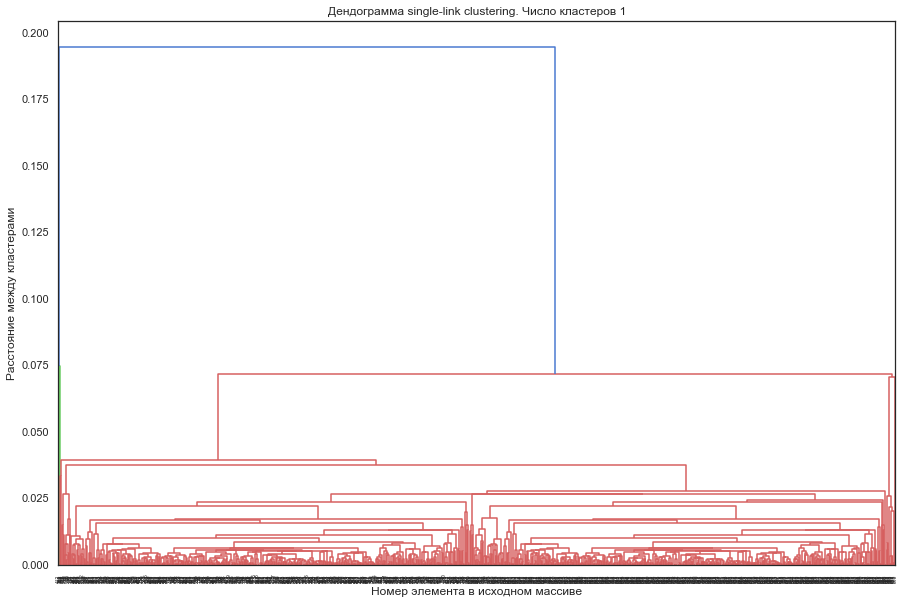

In [31]:
SingleLink(d).draw()

## Вывод:

Нет таких параметров "высоты" (расстояния между кластерами) и количества кластеров, чтобы получить два очевидных кластера. Или их очень сложно подобрать, алгоритм работает плохо!

# Пример 3:

In [32]:
d = np.concatenate((np.random.RandomState(10).normal(size=1000)/3, np.random.RandomState(100).normal(size=1000)/3+2,
                   np.random.RandomState(200).normal(size=1000)/3+3.8))

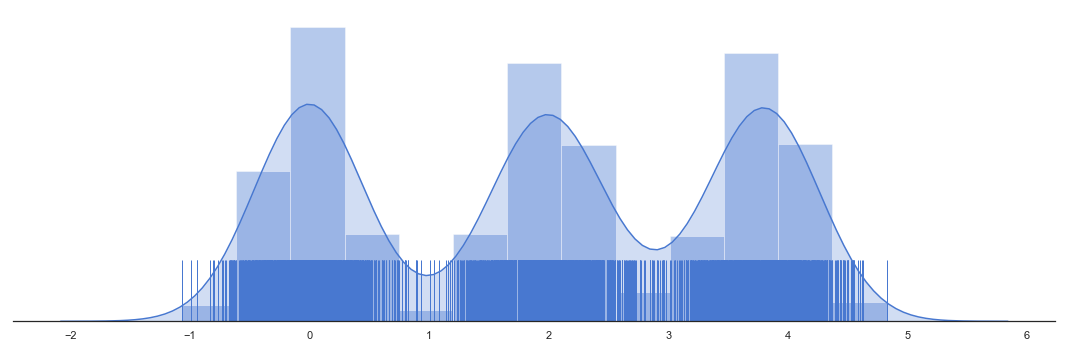

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:
Три больших кластера с центрами в 0, 2 и 4

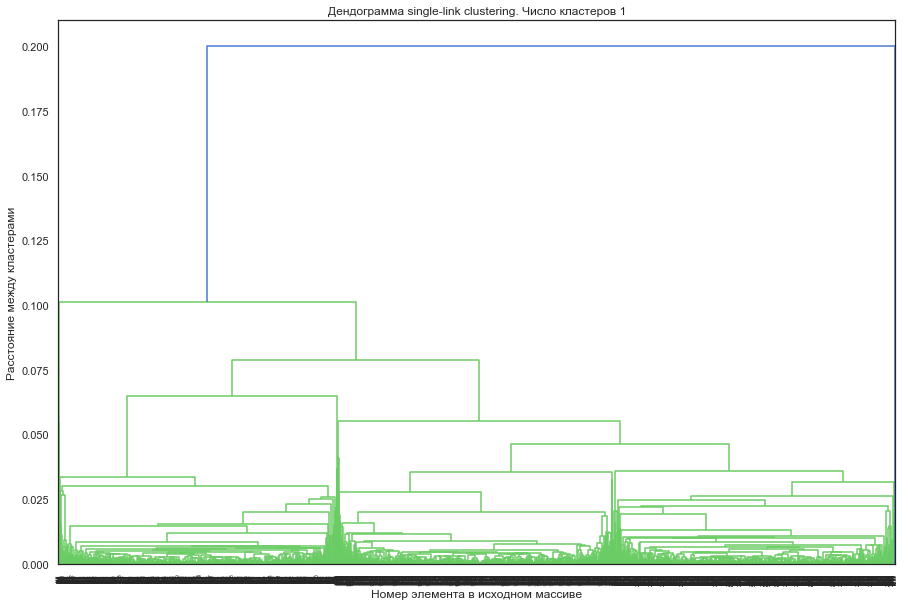

In [34]:
SingleLink(d).draw()

# Вывод:

Хоть мы и можем по косвенным признакам понять, что есть три кластера (сгущения вертикальных линий), это нам не помогает сильнее, чем график seaborn. Нет таких параметров (расстояние между кластерами или их количество), по которым можно было предъявить в SingleLink'е нужные кластеры